In [1]:
import glob
import unicodedata
import string

all_letters = string.ascii_letters+",.;'-"
n_letters = len(all_letters)
EOS = n_letters-1

# turn the unicode string to plain ASCII 
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c)!='Mn' and c in all_letters)

print(unicode_to_ascii('~`Abhi'))

Abhi


In [2]:
# read a file and split it into lines
def read_lines(filename):
    lines = open(filename,encoding='utf8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

# build the category lines dictonary, a list of lines per category
category_lines = {}
all_category = []

for filename in glob.glob(r'C:\Users\Syahrir Ridha\pytorch\recurrent\data\data\names\*.txt'):
    category = filename.split('\\')[-1].split('.')[0]
    all_category.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines
    
n_category = len(all_category)
print('Category: {} {}'.format(n_category, all_category))

Category: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


In [3]:
category_lines['Arabic'][:5]

['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari']

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self,input_size, hidden_size,out_size, n_layer):
        super(RNN,self).__init__()
        self.input_size, self.hidden_size, self.out_size, self.layers = input_size, hidden_size,out_size, n_layer
        
        ## define different layers
        self.i2h = nn.Linear(n_category+input_size+hidden_size,hidden_size)
        self.i2o = nn.Linear(n_category+input_size+hidden_size,out_size)
        self.o2o = nn.Linear(hidden_size+out_size,out_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self,x,category,hidden):
        input_combined = torch.cat((category,x,hidden),1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden,output),1)
        output = self.o2o(output_combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.zeros(1,self.hidden_size))

In [5]:
# create random training function
import random

def random_train():
    category = random.choice(all_category)
    line = random.choice(category_lines[category])
    return category, line

In [6]:
torch.zeros(1,n_category).shape

torch.Size([1, 18])

In [7]:
# one hot vector for category
def make_category_input(category):
    li = all_category.index(category)
    tensor = torch.zeros(1,n_category)
    tensor[0][li] = 1
    return tensor

# one hot matrix for first to last letters (not including EOS) for input
def make_char_input(chars):
    tensor = torch.zeros(len(chars),n_letters)
    for ci in range(len(chars)):
        char = chars[ci]
        tensor[ci][all_letters.find(char)] =1
    tensor = tensor.view(-1,1,n_letters)
    return Variable(tensor)

# log tensor of second letter to end (EOS) for target
def make_target(line):
    letter_indexes = [all_letters.find(line[i]) for i in range(1,len(line))]
    letter_indexes.append(n_letters-1) # EOS
    tensor = torch.LongTensor(letter_indexes)
    return tensor

In [8]:
def random_training_set():
    category, line = random_train()
    category_input = make_category_input(category)
    line_input = make_char_input(line)
    line_target = make_target(line)
    return category_input, line_input, line_target

In [9]:
def train(category_tensor,input_line_tensor,target_line_tensor):
    hidden = rnn.init_hidden()
    optimizer.zero_grad()
    target_line_tensor.unsqueeze_(-1)
    loss = 0
    
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor,input_line_tensor[i],hidden)
        loss += error(output,target_line_tensor[i])
        
        
    loss.backward()
    optimizer.step()
    
    return output, loss.data/input_line_tensor.size()[0]

In [10]:
import time
import math

def time_since(start):
    now = time.time()
    s = now - start
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds'%(m,s)

In [12]:
n_epochs = 100000
print_every = 5000
plot_every = 500
all_losses = []
loss_avg = 0
learning_rate = 0.0005

# start model
rnn = RNN(n_letters,128,n_letters,1)
optimizer = torch.optim.Adam(rnn.parameters(),lr=learning_rate)
error = nn.NLLLoss()

start_time = time.time()

for epoch in range(1,n_epochs+1):
    output,loss = train(*random_training_set())
    loss_avg += loss
    
    if epoch%print_every ==0:
        print('%s (%d %d%%) %.4f'%(time_since(start_time),epoch,epoch/n_epochs*100,loss))
        
    if epoch % plot_every==0:
        all_losses.append(loss_avg/plot_every)
        loss_avg =0

0m 30s (5000 5%) 2.0803
1m 4s (10000 10%) 2.2860
1m 36s (15000 15%) 2.5920
2m 8s (20000 20%) 1.8771
2m 40s (25000 25%) 2.7390
3m 13s (30000 30%) 2.6954
3m 45s (35000 35%) 2.3546
4m 17s (40000 40%) 0.9341
4m 49s (45000 45%) 1.7235
5m 21s (50000 50%) 1.4522
5m 51s (55000 55%) 0.8464
6m 22s (60000 60%) 2.8223
6m 54s (65000 65%) 1.4396
7m 25s (70000 70%) 2.7842
7m 57s (75000 75%) 2.1764
8m 29s (80000 80%) 1.5354
9m 1s (85000 85%) 1.7046
9m 33s (90000 90%) 1.7686
10m 6s (95000 95%) 1.7524
10m 38s (100000 100%) 1.5591


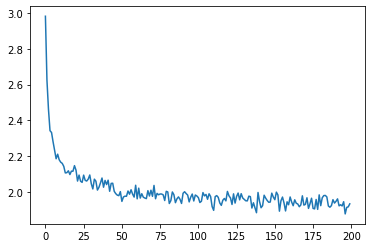

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(all_losses)

In [17]:
max_length = 20

# generate given category and starting letter
def generate_name(category,start_char='A',temp=0.5):
    category_input = make_category_input(category)
    chars_input = make_char_input(start_char)
    hidden = rnn.init_hidden()
    
    output_str = start_char
    
    for i in range(max_length):
        output, hidden = rnn(category_input,chars_input[0],hidden)
        
        # sample as a multinomial distribution
        output_dist = output.data.view(-1).div(temp).exp()
        top_i = torch.multinomial(output_dist,1)[0]
        
        # stop at EOS
        if top_i == EOS:
            break
        else:
            char = all_letters[top_i]
            output_str += char
            chars_input = make_char_input(char)
            
    return output_str

# get multiple samples from one category and multiple starting letters
def generate(category,start_chars='ABC'):
    for start_char in start_chars:
        print(generate_name(category,start_char))

In [18]:
generate('Russian','RUS')

Rosthin
Urtskh
Shankh


In [20]:
generate('Arabic','MAD')

Malah
Abarg
Dase
